# YOLOV3目标检测

YOLOV3算法精讲与论文逐句精读：同济子豪兄：https://space.bilibili.com/1900783

不注明出处的转载视为侵权。

2021-08-28

# 准备文件，导入工具包

YOLOV3-模型权重文件：https://pjreddie.com/darknet/yolo/

COCO数据集80个类别名称：https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [1]:
import cv2

import numpy as np

In [2]:
# 导入python绘图matplotlib
import matplotlib.pyplot as plt
# 使用ipython的魔法方法，将绘制出的图像直接嵌入在notebook单元格中
%matplotlib inline
# 定义可视化图像函数
def look_img(img):
    '''opencv读入图像格式为BGR，matplotlib可视化格式为RGB，因此需将BGR转RGB'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

# 导入预训练YOLOV3模型

In [3]:
net = cv2.dnn.readNet('yolov3.weights','yolov3.cfg')

# 导入COCO数据集80个类别

In [4]:
with open('coco.names','r') as f:
    classes = f.read().splitlines()

In [5]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

# 导入图像

In [6]:
img = cv2.imread('test.jpg')

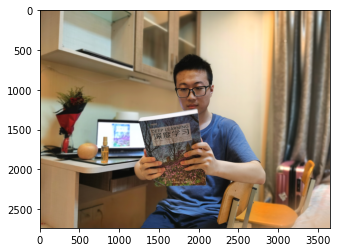

In [7]:
look_img(img)

In [8]:
img.shape

(2736, 3648, 3)

In [9]:
# 获取图像宽高
height, width, _ = img.shape

# 对图像预处理

In [10]:
blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), (0,0,0), swapRB=True, crop=False)

In [11]:
blob.shape

(1, 3, 416, 416)

In [12]:
net.setInput(blob)

# 探索YOLOV3神经网络

In [13]:
# 获取网络所有层名字
net.getLayerNames()

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

In [14]:
# # 获取某一层的权重值
# net.getParam('conv_14').shape

In [15]:
# 获取三个尺度输出层的索引号
net.getUnconnectedOutLayers()

array([200, 227, 254])

In [16]:
# 获取三个尺度输出层的名称
layersNames = net.getLayerNames()
# print(layersNames)
# output_layers_names = [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers_names = [layersNames[i-1] for i in net.getUnconnectedOutLayers()]
# output_layers_names

# 输入YOLOV3神经网络，前向推断预测

In [17]:
# 前向推断
prediction = net.forward(output_layers_names)

# 分析YOLOV3三个尺度的输出结果

In [18]:
len(prediction)

3

In [19]:
prediction[0].shape

(507, 85)

In [20]:
prediction[1].shape

(2028, 85)

In [21]:
prediction[2].shape

(8112, 85)

$13 \times 13 \times 3 = 507$

$26 \times 26 \times 3 = 2028$

$52 \times 52 \times 3 = 8112$

In [22]:
# 查看第二个尺度，索引为99的框的85维向量
prediction[1][99].shape

(85,)

In [23]:
prediction[1][99]

array([2.8310129e-01, 6.0586039e-02, 7.1901433e-02, 1.0788218e-01,
       8.8670640e-07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

# 从三个尺度输出结果中解析所有预测框信息

In [24]:
# 存放预测框坐标
boxes = []

# 存放置信度
objectness = []

# 存放类别概率
class_probs = []

# 存放预测框类别索引号
class_ids = []

# 存放预测框类别名称
class_names = []

In [25]:
for scale in prediction: # 遍历三种尺度
    for bbox in scale: # 遍历每个预测框
        obj = bbox[4] # 获取该预测框的confidence（objectness）
        class_scores = bbox[5:] # 获取该预测框在COCO数据集80个类别的概率
        class_id = np.argmax(class_scores) # 获取概率最高类别的索引号
        class_name = classes[class_id] # 获取概率最高类别的名称
        class_prob = class_scores[class_id] # 获取概率最高类别的概率
        
        # 获取预测框中心点坐标、预测框宽高
        center_x = int(bbox[0] * width)
        center_y = int(bbox[1] * height)
        w = int(bbox[2] * width)
        h = int(bbox[3] * height)
        # 计算预测框左上角坐标
        x = int(center_x - w/2)
        y = int(center_y - h/2)
        
        # 将每个预测框的结果存放至上面的列表中
        boxes.append([x, y, w, h])
        objectness.append(float(obj))
        class_ids.append(class_id)
        class_names.append(class_name)
        class_probs.append(class_prob)

In [26]:
boxes

[[-646, -49, 1527, 367],
 [-430, -981, 1182, 2147],
 [-1294, -1038, 2910, 2274],
 [-46, -21, 1044, 343],
 [-93, -749, 1097, 1683],
 [-866, -967, 2637, 2154],
 [131, -2, 1110, 339],
 [126, -622, 1147, 1444],
 [-681, -878, 2844, 1986],
 [216, -8, 1540, 308],
 [276, -563, 1492, 1347],
 [-338, -840, 2667, 1918],
 [462, -18, 1593, 329],
 [518, -537, 1457, 1340],
 [-78, -870, 2732, 1969],
 [757, -27, 1586, 333],
 [880, -631, 1341, 1500],
 [153, -827, 2901, 1891],
 [809, -15, 2042, 311],
 [1065, -616, 1579, 1451],
 [282, -785, 3170, 1804],
 [1163, -21, 1925, 311],
 [1322, -574, 1613, 1349],
 [631, -803, 3040, 1832],
 [1489, -8, 1797, 300],
 [1609, -607, 1602, 1388],
 [827, -823, 3140, 1857],
 [1708, 4, 1875, 258],
 [1862, -611, 1585, 1393],
 [1038, -823, 3225, 1834],
 [2120, 17, 1565, 245],
 [2239, -707, 1375, 1611],
 [1369, -914, 3194, 2033],
 [2429, 5, 1490, 269],
 [2593, -778, 1216, 1762],
 [1780, -921, 2906, 2075],
 [2516, -55, 1906, 311],
 [2916, -999, 1174, 2166],
 [1919, -993, 3218, 21

In [27]:
len(boxes)

10647

In [28]:
len(objectness)

10647

# 将预测框置信度objectness与各类别置信度class_pred相乘，获得最终该预测框的置信度confidence

In [29]:
confidences = np.array(class_probs) * np.array(objectness)

In [30]:
len(confidences)

10647

# objectness、class_pred、confidence三者的关系

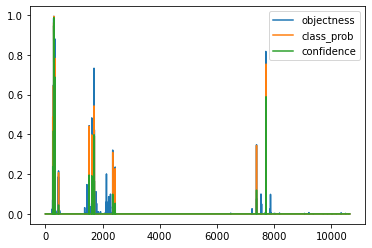

In [31]:
plt.plot(objectness, label='objectness')
plt.plot(class_probs, label='class_prob')
plt.plot(confidences, label='confidence')
plt.legend()
plt.show()

# 置信度过滤、非极大值抑制NMS

In [32]:
CONF_THRES = 0.1 # 指定置信度阈值，阈值越大，置信度过滤越强
NMS_THRES = 0.4 # 指定NMS阈值，阈值越小，NMS越强

In [33]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRES, NMS_THRES)

In [34]:
indexes.flatten()

array([ 296,  288, 7717,  282, 7709, 1529, 7384])

In [35]:
len(indexes.flatten())

7

In [36]:
# 随机给每个预测框生成一种颜色
# colors = np.random.uniform(0, 255, size=(len(boxes),3))
colors = [[255,0,255],[0,0,255],[0,255,255],[0,255,0],[255,255,0],[255,0,0],[180,187,28],[223,155,6],[94,218,121],[139,0,0],[77,169,10],[29,123,243],[66,77,229],[1,240,255],[140,47,240],[31,41,81],[29,123,243],[16,144,247],[151,57,224]]

In [37]:
# 遍历留下的每一个预测框，可视化
for i in indexes.flatten():
    
    # 获取坐标
    x, y, w, h = boxes[i]
    # 获取置信度
    confidence = str(round(confidences[i],2))
    # 获取颜色，画框
    color = colors[i%len(colors)]
    cv2.rectangle(img, (x,y), (x+w,y+h), color, 8)
    
    # 写类别名称和置信度
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
    string = '{} {}'.format(class_names[i], confidence)
    cv2.putText(img, string, (x, y+20), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255),5)

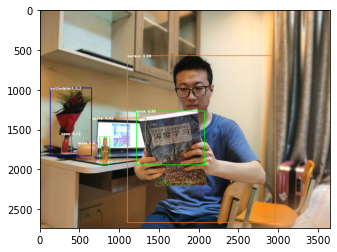

In [38]:
look_img(img)

In [39]:
# 保存图片
cv2.imwrite('result-test.jpg',img)

True